# Cross Validation
We've looked at a range of topics involved with fitting a model to data. This began with the simplest of regression cases and determining criteria for an optimal model, which led us to mean squarred error. From there, we further examined overfitting and underfitting which motivated train test split and later, the bias variance tradeoff. Here, we synthesize many of these ideas into a new sampling, optimization meta-routine known as cross validation. 

A common form of cross validation is known as K-folds. In this process, the dataset is partitioned into K equally sized groups. Each group is then used as a hold out test set while the remaining k-1 groups are used as a training set. This then produces K different models, one for each of the hold out test sets. These models can then be averaged (perhaps a weighted average based on their test set performance) in order to produce a finalized model.

This is also a very useful method for helping to determine the generalization of our models, or the anticipated difference between train and test errors for the model.

## 1. K-Folds
Write a function k-folds that splits a dataset into k evenly sized pieces.
If the full dataset is not divisible by k, make the first few folds one larger then later ones.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
def kfolds(data, k):
    #Force data as pandas dataframe (optional but could be helpful)
    df = pd.DataFrame(data)
    num_obs = len(data)
    fold_size = num_obs//k
    remainder = num_obs%k
    folds = []
    start_obs = 0
    
    for fold_n in range(1, k+1):
        if fold_n <= remainder:
            #Be sure to account for the case where the dataset is not evenly divisible
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
    
    return folds #folds should be a list of subsets of data

## 2. Cross Validation
* Split your dataset into 10 groups using your kfolds function above.
* Perform linear regression on each and calculate the training and test error. 
* Create a simple bar chart to display the various train and test errors for each of the 10 folds.

In [3]:
df = pd.read_excel('movie_data_detailed_with_ols.xlsx')
X_feats = ['budget', 'imdbRating',
       'Metascore', 'imdbVotes']
y_feat = 'domgross'
df.head()

,budget,domgross,title,Response_Json,Year,imdbRating,Metascore,imdbVotes,Model
0,13000000,25682380,21 &amp; Over,0,2008,6.8,48,206513,4.912759e+07
1,45658735,13414714,Dredd 3D,0,2012,0.0,0,0,2.267265e+05
2,20000000,53107035,12 Years a Slave,0,2013,8.1,96,537525,1.626624e+08
3,61000000,75612460,2 Guns,0,2013,6.7,55,173726,7.723381e+07
4,40000000,95020213,42,0,2013,7.5,62,74170,4.151958e+07


In [4]:
folds = kfolds(df, k=10)

# Previews, just to demonstrate

In [5]:
#folds[0]
folds[0]

,budget,domgross,title,Response_Json,Year,imdbRating,Metascore,imdbVotes,Model
0,13000000,25682380,21 &amp; Over,0,2008,6.8,48,206513,4.912759e+07
1,45658735,13414714,Dredd 3D,0,2012,0.0,0,0,2.267265e+05
2,20000000,53107035,12 Years a Slave,0,2013,8.1,96,537525,1.626624e+08


In [6]:
#folds[1]
folds[1]

,budget,domgross,title,Response_Json,Year,imdbRating,Metascore,imdbVotes,Model
3,61000000,75612460,2 Guns,0,2013,6.7,55,173726,7.723381e+07
4,40000000,95020213,42,0,2013,7.5,62,74170,4.151958e+07
5,225000000,38362475,47 Ronin,0,2013,6.3,28,128766,1.605898e+08


In [7]:
# folds[8]
folds[8]

,budget,domgross,title,Response_Json,Year,imdbRating,Metascore,imdbVotes,Model
24,17000000,54239856,Evil Dead,0,2013,6.5,57,139940,4.076999e+07
25,160000000,238679850,Fast and Furious 6,0,0,0.0,0,0,2.383743e+08
26,150000000,393050114,Frozen,0,2013,7.5,74,483555,2.242330e+08


In [8]:
# folds[9]
folds[9]

,budget,domgross,title,Response_Json,Year,imdbRating,Metascore,imdbVotes,Model
27,140000000,122523060,G.I. Joe: Retaliation,0,2013,5.8,41,158210,1.193156e+08
28,60000000,46000903,Gangster Squad,0,2013,6.7,40,188846,7.125032e+07
29,30000000,4167493,Gloria,0,1980,7.1,0,0,-1.783223e+07


In [9]:
def mse(residual_col):
#     residual_col = pd.Series(residual_col)
    return np.mean(residual_col.astype(float).map(lambda x: x**2))

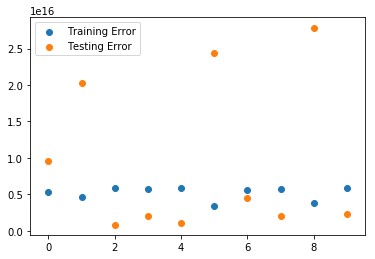

In [13]:
test_errs = []
train_errs = []
k=10

for n in range(k):
    #Split into the train and test sets for this fold
    train = pd.concat([fold for i, fold in enumerate(folds) if i !=n])
    test = folds[n]
    #Fit Linear Regression Model
    ols = LinearRegression()
    ols.fit(train[X_feats], train[y_feat])
    y_hat_train = ols.predict(train[X_feats])
    y_hat_test = ols.predict(test[X_feats])
    train_residuals = y_hat_train - train[y_feat]
    test_residuals = y_hat_test - test[y_feat]
    #Evaluate Train and Test Errors
    y_hat_train = ols.predict(train[X_feats])
    y_hat_test = ols.predict(test[X_feats])
    train_errs.append(mse(train_residuals))
    test_errs.append(mse(test_residuals))
#Plot Train Versus Test Errors for each of the 10 folds
plt.bar(list(range(k)), train_errs, label='Training Error')
plt.bar(list(range(k)), test_errs, label='Testing Error')
plt.legend();

## 4. Analysis
What do you notice about the train and test errors?

In [ ]:
#Your answer here

## 5. Shuffling Datasets
Write a function to randomly sort your dataset prior to cross validation.  
Why  might you want to do this?

In [ ]:
#Your function here

In [ ]:
#Your answer here